In [1]:

import os
import sys
import math
import random
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

import tensorflow as tf
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.layers import Embedding, Dense, Flatten, LSTM, Bidirectional, Dropout

print("Python version:", sys.version)
print("TensorFlow version:", tf.__version__)
print("GPU devices:", tf.config.list_physical_devices("GPU"))


Python version: 3.12.10 (tags/v3.12.10:0cc8128, Apr  8 2025, 12:21:36) [MSC v.1943 64 bit (AMD64)]
TensorFlow version: 2.20.0
GPU devices: []


In [2]:
# IMDB 数据集配置
MAX_FEATURES = 10000   # 使用最常见的前 10,000 个单词
MAXLEN_DEFAULT = 200   # 默认序列长度

# 为了训练速度，我们只使用部分样本
N_TRAIN_SAMPLES = 20000
N_TEST_SAMPLES  = 10000

BATCH_SIZE = 128

# 嵌入层实验用的超参数候选（实验 1-1）
MAXLEN_LIST = [100, 200, 300]     # 不同的样本长度
EMBED_DIM_LIST = [8, 16, 32]      # 不同的词向量维度
EPOCHS_EMBED = 5                  # 每个组合训练轮数

# RNN 实验（实验 2）超参数
MAXLEN_RNN = 200
EMBED_DIM_RNN = 32
EPOCHS_RNN = 5                    # LSTM / 堆叠 LSTM / BiLSTM 的训练轮数

print("MAX_FEATURES:", MAX_FEATURES)
print("N_TRAIN_SAMPLES:", N_TRAIN_SAMPLES, "N_TEST_SAMPLES:", N_TEST_SAMPLES)


MAX_FEATURES: 10000
N_TRAIN_SAMPLES: 20000 N_TEST_SAMPLES: 10000


In [3]:
# num_words=MAX_FEATURES: 只保留词频最高的 MAX_FEATURES 个单词
(x_train_raw, y_train_raw), (x_test_raw, y_test_raw) = imdb.load_data(num_words=MAX_FEATURES)

print("原始训练集大小:", len(x_train_raw))
print("原始测试集大小:", len(x_test_raw))

# 为了节省时间，截取前 N_TRAIN_SAMPLES / N_TEST_SAMPLES 条样本
x_train_raw = x_train_raw[:N_TRAIN_SAMPLES]
y_train_raw = y_train_raw[:N_TRAIN_SAMPLES]
x_test_raw  = x_test_raw[:N_TEST_SAMPLES]
y_test_raw  = y_test_raw[:N_TEST_SAMPLES]

print("使用的训练集大小:", len(x_train_raw))
print("使用的测试集大小:", len(x_test_raw))
print("示例原始序列（前 1 条）:", x_train_raw[0][:20], "...")


17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
原始训练集大小: 25000
原始测试集大小: 25000
使用的训练集大小: 20000
使用的测试集大小: 10000
示例原始序列（前 1 条）: [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25] ...


In [4]:
def plot_history(history, title_prefix=""):
    """绘制 accuracy / loss 曲线。"""
    acc = history.history.get("acc") or history.history.get("accuracy")
    val_acc = history.history.get("val_acc") or history.history.get("val_accuracy")
    loss = history.history.get("loss")
    val_loss = history.history.get("val_loss")

    epochs = range(1, len(acc) + 1)

    plt.figure()
    plt.plot(epochs, acc, "bo", label="Training acc")
    plt.plot(epochs, val_acc, "b", label="Validation acc")
    plt.title(f"{title_prefix} Training and validation accuracy")
    plt.legend()

    plt.figure()
    plt.plot(epochs, loss, "bo", label="Training loss")
    plt.plot(epochs, val_loss, "b", label="Validation loss")
    plt.title(f"{title_prefix} Training and validation loss")
    plt.legend()

    plt.show()


## 词嵌入进行电影评论分类

In [5]:
def build_embedding_model(maxlen, embedding_dim):
    """构建一个 Embedding + Flatten + Dense 的简单网络。"""
    model = models.Sequential()
    model.add(Embedding(MAX_FEATURES, embedding_dim, input_length=maxlen))
    model.add(Flatten())
    model.add(Dense(1, activation="sigmoid"))
    model.compile(
        optimizer="rmsprop",
        loss="binary_crossentropy",
        metrics=["acc"]
    )
    return model



=== 当前样本长度 maxlen = 100 ===
x_train shape: (20000, 100) x_test shape: (10000, 100)

--> 训练模型：maxlen=100, embedding_dim=8


C:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
125/125 - 1s - 5ms/step - acc: 0.5889 - loss: 0.6838 - val_acc: 0.6945 - val_loss: 0.6600
Epoch 2/5
125/125 - 0s - 2ms/step - acc: 0.7588 - loss: 0.5935 - val_acc: 0.7703 - val_loss: 0.5341
Epoch 3/5
125/125 - 0s - 2ms/step - acc: 0.8216 - loss: 0.4634 - val_acc: 0.8110 - val_loss: 0.4376
Epoch 4/5
125/125 - 0s - 2ms/step - acc: 0.8525 - loss: 0.3803 - val_acc: 0.8230 - val_loss: 0.3883
Epoch 5/5
125/125 - 0s - 2ms/step - acc: 0.8734 - loss: 0.3298 - val_acc: 0.8380 - val_loss: 0.3601
[结果] maxlen=100, embedding_dim=8, test_acc=0.8393


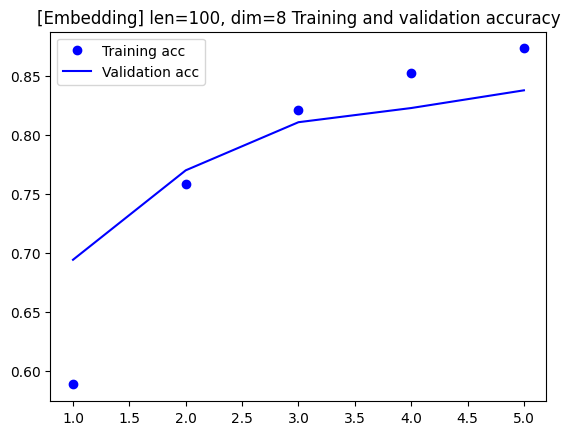

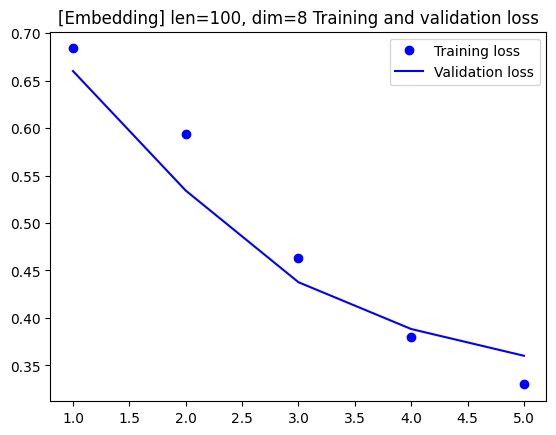


--> 训练模型：maxlen=100, embedding_dim=16


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
125/125 - 1s - 5ms/step - acc: 0.5864 - loss: 0.6841 - val_acc: 0.6910 - val_loss: 0.6581
Epoch 2/5
125/125 - 0s - 2ms/step - acc: 0.7668 - loss: 0.5714 - val_acc: 0.7795 - val_loss: 0.5034
Epoch 3/5
125/125 - 0s - 2ms/step - acc: 0.8307 - loss: 0.4274 - val_acc: 0.8135 - val_loss: 0.4114
Epoch 4/5
125/125 - 0s - 2ms/step - acc: 0.8622 - loss: 0.3483 - val_acc: 0.8317 - val_loss: 0.3667
Epoch 5/5
125/125 - 0s - 2ms/step - acc: 0.8855 - loss: 0.3005 - val_acc: 0.8422 - val_loss: 0.3470
[结果] maxlen=100, embedding_dim=16, test_acc=0.8424


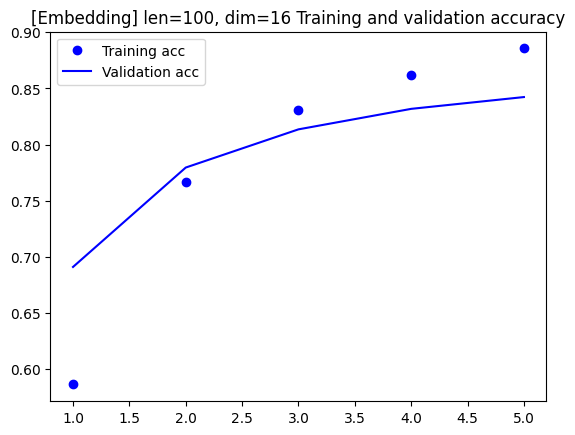

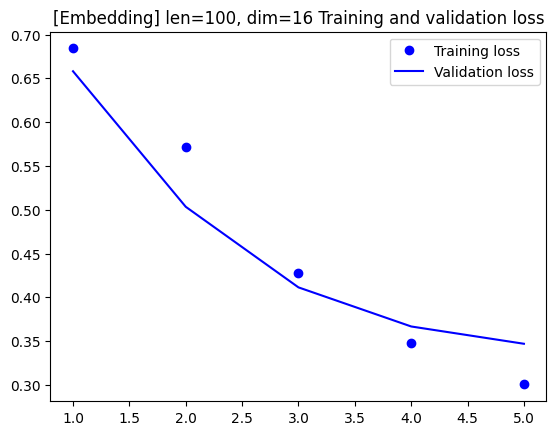


--> 训练模型：maxlen=100, embedding_dim=32


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
125/125 - 1s - 5ms/step - acc: 0.6052 - loss: 0.6765 - val_acc: 0.7063 - val_loss: 0.6291
Epoch 2/5
125/125 - 0s - 2ms/step - acc: 0.7813 - loss: 0.5234 - val_acc: 0.8002 - val_loss: 0.4571
Epoch 3/5
125/125 - 0s - 2ms/step - acc: 0.8431 - loss: 0.3871 - val_acc: 0.8245 - val_loss: 0.3845
Epoch 4/5
125/125 - 0s - 2ms/step - acc: 0.8736 - loss: 0.3205 - val_acc: 0.8385 - val_loss: 0.3541
Epoch 5/5
125/125 - 0s - 2ms/step - acc: 0.8971 - loss: 0.2741 - val_acc: 0.8372 - val_loss: 0.3523
[结果] maxlen=100, embedding_dim=32, test_acc=0.8363


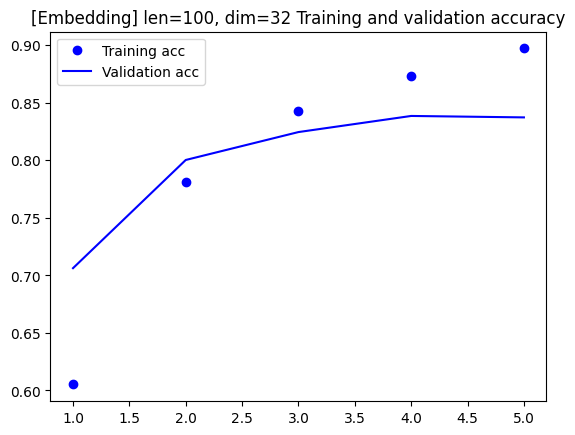

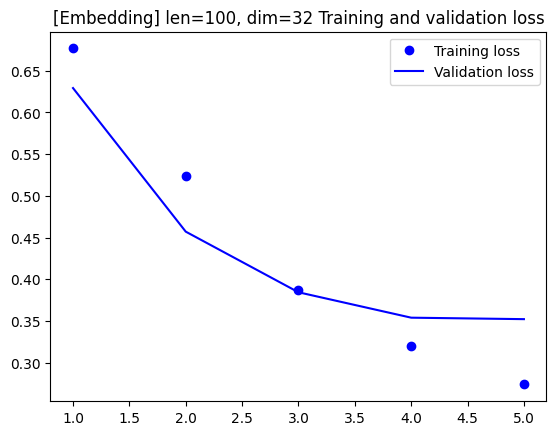


=== 当前样本长度 maxlen = 200 ===
x_train shape: (20000, 200) x_test shape: (10000, 200)

--> 训练模型：maxlen=200, embedding_dim=8


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
125/125 - 1s - 6ms/step - acc: 0.5634 - loss: 0.6870 - val_acc: 0.6528 - val_loss: 0.6677
Epoch 2/5
125/125 - 0s - 3ms/step - acc: 0.7554 - loss: 0.5858 - val_acc: 0.7985 - val_loss: 0.5089
Epoch 3/5
125/125 - 0s - 3ms/step - acc: 0.8314 - loss: 0.4315 - val_acc: 0.8347 - val_loss: 0.3968
Epoch 4/5
125/125 - 0s - 3ms/step - acc: 0.8607 - loss: 0.3502 - val_acc: 0.8455 - val_loss: 0.3480
Epoch 5/5
125/125 - 0s - 3ms/step - acc: 0.8831 - loss: 0.2973 - val_acc: 0.8540 - val_loss: 0.3238
[结果] maxlen=200, embedding_dim=8, test_acc=0.8565


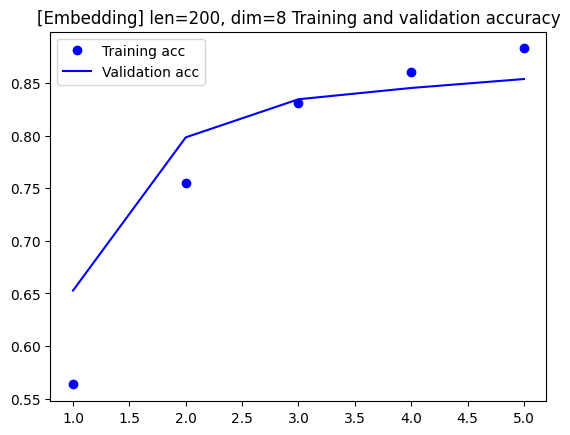

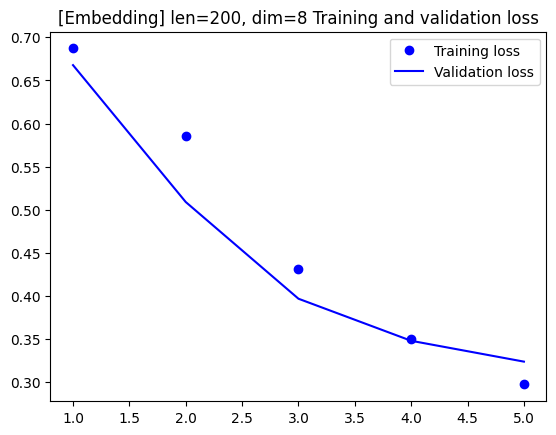


--> 训练模型：maxlen=200, embedding_dim=16


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
125/125 - 1s - 6ms/step - acc: 0.6068 - loss: 0.6758 - val_acc: 0.7272 - val_loss: 0.6250
Epoch 2/5
125/125 - 0s - 4ms/step - acc: 0.7853 - loss: 0.5194 - val_acc: 0.8020 - val_loss: 0.4473
Epoch 3/5
125/125 - 0s - 4ms/step - acc: 0.8463 - loss: 0.3824 - val_acc: 0.8407 - val_loss: 0.3675
Epoch 4/5
125/125 - 0s - 4ms/step - acc: 0.8728 - loss: 0.3153 - val_acc: 0.8540 - val_loss: 0.3290
Epoch 5/5
125/125 - 0s - 4ms/step - acc: 0.8969 - loss: 0.2687 - val_acc: 0.8572 - val_loss: 0.3186
[结果] maxlen=200, embedding_dim=16, test_acc=0.8605


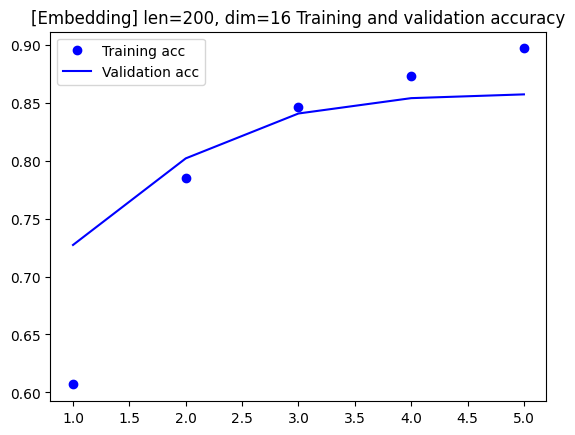

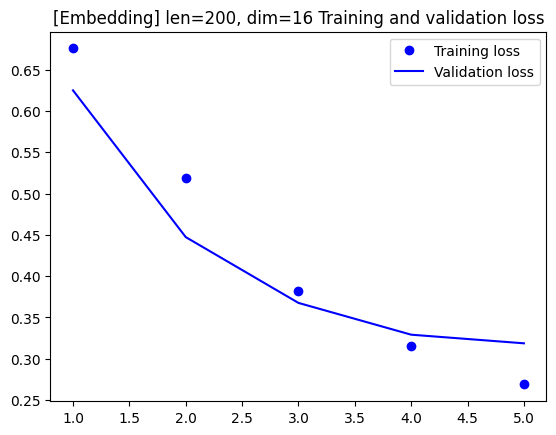


--> 训练模型：maxlen=200, embedding_dim=32


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
125/125 - 1s - 6ms/step - acc: 0.6159 - loss: 0.6646 - val_acc: 0.7425 - val_loss: 0.5817
Epoch 2/5
125/125 - 0s - 4ms/step - acc: 0.8006 - loss: 0.4734 - val_acc: 0.7960 - val_loss: 0.4412
Epoch 3/5
125/125 - 0s - 4ms/step - acc: 0.8522 - loss: 0.3533 - val_acc: 0.8232 - val_loss: 0.3836
Epoch 4/5
125/125 - 0s - 4ms/step - acc: 0.8786 - loss: 0.2986 - val_acc: 0.8612 - val_loss: 0.3294
Epoch 5/5
125/125 - 0s - 4ms/step - acc: 0.8982 - loss: 0.2568 - val_acc: 0.8583 - val_loss: 0.3160
[结果] maxlen=200, embedding_dim=32, test_acc=0.8582


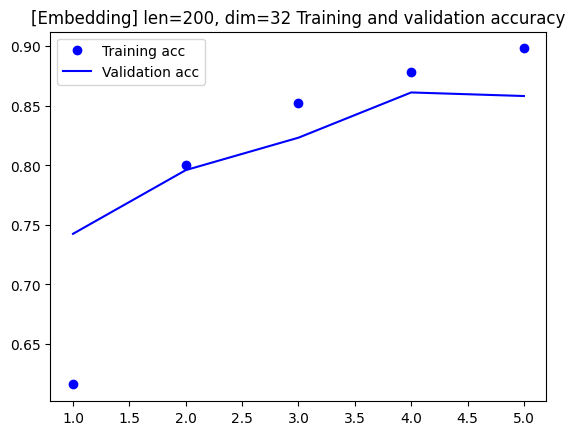

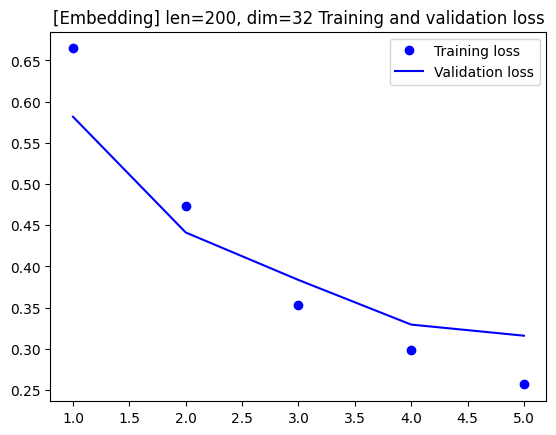


=== 当前样本长度 maxlen = 300 ===
x_train shape: (20000, 300) x_test shape: (10000, 300)

--> 训练模型：maxlen=300, embedding_dim=8


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
125/125 - 1s - 8ms/step - acc: 0.5661 - loss: 0.6843 - val_acc: 0.6530 - val_loss: 0.6577
Epoch 2/5
125/125 - 1s - 6ms/step - acc: 0.7564 - loss: 0.5646 - val_acc: 0.7890 - val_loss: 0.4861
Epoch 3/5
125/125 - 1s - 5ms/step - acc: 0.8332 - loss: 0.4166 - val_acc: 0.8205 - val_loss: 0.3941
Epoch 4/5
125/125 - 1s - 6ms/step - acc: 0.8627 - loss: 0.3382 - val_acc: 0.8443 - val_loss: 0.3479
Epoch 5/5
125/125 - 1s - 6ms/step - acc: 0.8859 - loss: 0.2913 - val_acc: 0.8537 - val_loss: 0.3315
[结果] maxlen=300, embedding_dim=8, test_acc=0.8451


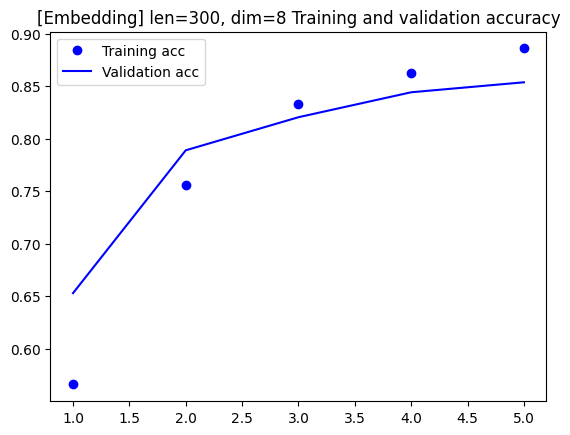

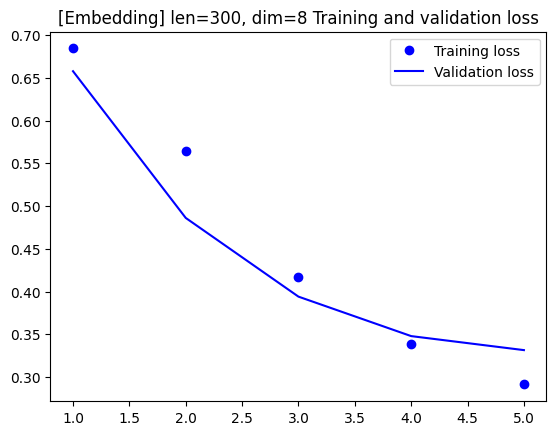


--> 训练模型：maxlen=300, embedding_dim=16


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
125/125 - 1s - 8ms/step - acc: 0.5701 - loss: 0.6826 - val_acc: 0.7017 - val_loss: 0.6431
Epoch 2/5
125/125 - 1s - 6ms/step - acc: 0.7703 - loss: 0.5353 - val_acc: 0.7815 - val_loss: 0.4674
Epoch 3/5
125/125 - 1s - 6ms/step - acc: 0.8398 - loss: 0.3897 - val_acc: 0.8393 - val_loss: 0.3686
Epoch 4/5
125/125 - 1s - 6ms/step - acc: 0.8729 - loss: 0.3157 - val_acc: 0.8338 - val_loss: 0.3654
Epoch 5/5
125/125 - 1s - 6ms/step - acc: 0.8954 - loss: 0.2693 - val_acc: 0.8577 - val_loss: 0.3235
[结果] maxlen=300, embedding_dim=16, test_acc=0.8545


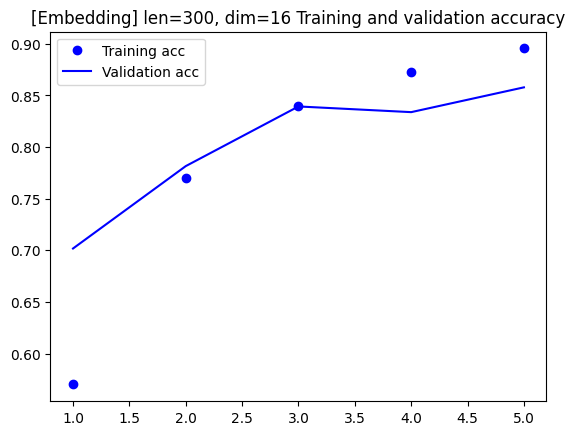

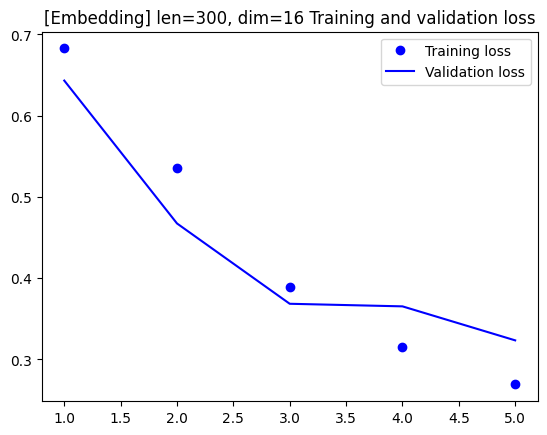


--> 训练模型：maxlen=300, embedding_dim=32


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
125/125 - 1s - 8ms/step - acc: 0.5970 - loss: 0.6713 - val_acc: 0.7285 - val_loss: 0.6019
Epoch 2/5
125/125 - 1s - 6ms/step - acc: 0.7962 - loss: 0.4855 - val_acc: 0.8018 - val_loss: 0.4290
Epoch 3/5
125/125 - 1s - 6ms/step - acc: 0.8559 - loss: 0.3531 - val_acc: 0.8112 - val_loss: 0.3975
Epoch 4/5
125/125 - 1s - 6ms/step - acc: 0.8882 - loss: 0.2853 - val_acc: 0.8515 - val_loss: 0.3305
Epoch 5/5
125/125 - 1s - 5ms/step - acc: 0.9112 - loss: 0.2406 - val_acc: 0.8610 - val_loss: 0.3155
[结果] maxlen=300, embedding_dim=32, test_acc=0.8593


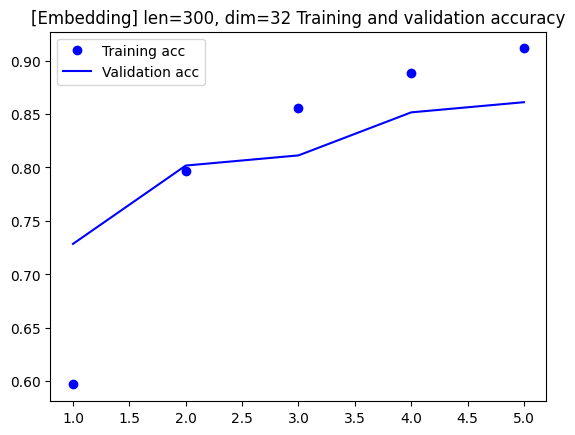

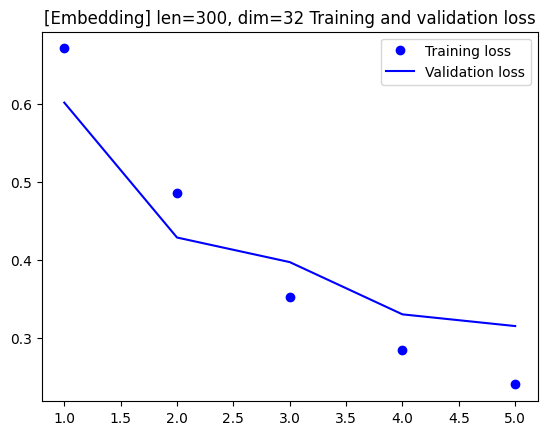


=== 不同参数组合的测试集结果汇总 ===
[
    {
        "maxlen": 100,
        "embedding_dim": 8,
        "test_loss": 0.3666248619556427,
        "test_acc": 0.8392999768257141
    },
    {
        "maxlen": 100,
        "embedding_dim": 16,
        "test_loss": 0.3551056683063507,
        "test_acc": 0.8424000144004822
    },
    {
        "maxlen": 100,
        "embedding_dim": 32,
        "test_loss": 0.3609813451766968,
        "test_acc": 0.8363000154495239
    },
    {
        "maxlen": 200,
        "embedding_dim": 8,
        "test_loss": 0.32970595359802246,
        "test_acc": 0.8565000295639038
    },
    {
        "maxlen": 200,
        "embedding_dim": 16,
        "test_loss": 0.32428815960884094,
        "test_acc": 0.8604999780654907
    },
    {
        "maxlen": 200,
        "embedding_dim": 32,
        "test_loss": 0.32637152075767517,
        "test_acc": 0.8582000136375427
    },
    {
        "maxlen": 300,
        "embedding_dim": 8,
        "test_loss": 0.3409554064273834,
     

In [6]:
results_embed = []

for maxlen in MAXLEN_LIST:
    # 对当前 maxlen 重新进行 padding
    x_train = sequence.pad_sequences(x_train_raw, maxlen=maxlen)
    x_test  = sequence.pad_sequences(x_test_raw,  maxlen=maxlen)
    print("\n=== 当前样本长度 maxlen =", maxlen, "===")
    print("x_train shape:", x_train.shape, "x_test shape:", x_test.shape)

    for embedding_dim in EMBED_DIM_LIST:
        print(f"\n--> 训练模型：maxlen={maxlen}, embedding_dim={embedding_dim}")
        model = build_embedding_model(maxlen=maxlen, embedding_dim=embedding_dim)
        model.summary()

        history = model.fit(
            x_train, y_train_raw,
            epochs=EPOCHS_EMBED,
            batch_size=BATCH_SIZE,
            validation_split=0.2,
            verbose=2
        )

        test_loss, test_acc = model.evaluate(x_test, y_test_raw, verbose=0)
        print(f"[结果] maxlen={maxlen}, embedding_dim={embedding_dim}, test_acc={test_acc:.4f}")

        results_embed.append({
            "maxlen": maxlen,
            "embedding_dim": embedding_dim,
            "test_loss": float(test_loss),
            "test_acc": float(test_acc)
        })

        plot_history(history, title_prefix=f"[Embedding] len={maxlen}, dim={embedding_dim}")

import json
print("\n=== 不同参数组合的测试集结果汇总 ===")
print(json.dumps(results_embed, indent=4))


### One-Hot（词袋）/TF-IDF/词嵌入的对比  


示例文本： 1 14 22 16 43 530 973 1622 1385 65 458 4468 66 3941 4 173 36 256 5 25 100 43 838 112 50 670 2 9 35 480 284 5 150 4 172 112 167 2 336 385 39 4 172 4536 1111 17 546 38 13 447 4 192 50 16 6 147 2025 19 1 ...

=== 词袋模型（One-Hot / 计数） ===
BOW 特征矩阵形状： (20000, 9998)
BOW + LogisticRegression 测试集准确率: 0.8597

=== TF-IDF 模型 ===
TF-IDF 特征矩阵形状： (20000, 9998)
TF-IDF + LogisticRegression 测试集准确率: 0.8826

=== Embedding 神经网络 ===


C:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
125/125 - 1s - 6ms/step - acc: 0.6198 - loss: 0.6615 - val_acc: 0.7220 - val_loss: 0.5805
Epoch 2/5
125/125 - 0s - 4ms/step - acc: 0.7994 - loss: 0.4702 - val_acc: 0.7810 - val_loss: 0.4463
Epoch 3/5
125/125 - 0s - 3ms/step - acc: 0.8507 - loss: 0.3578 - val_acc: 0.8405 - val_loss: 0.3584
Epoch 4/5
125/125 - 0s - 4ms/step - acc: 0.8783 - loss: 0.3003 - val_acc: 0.8550 - val_loss: 0.3262
Epoch 5/5
125/125 - 0s - 4ms/step - acc: 0.9050 - loss: 0.2519 - val_acc: 0.8597 - val_loss: 0.3224
Embedding + NN 测试集准确率: 0.8566

=== 结果汇总 ===
{'bow_logreg': 0.8597, 'tfidf_logreg': 0.8826, 'embedding_nn': 0.8565999865531921}


C:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 36873 (\N{CJK UNIFIED IDEOGRAPH-9009}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 23450 (\N{CJK UNIFIED IDEOGRAPH-5B9A}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21442 (\N{CJK UNIFIED IDEOGRAPH-53C2}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


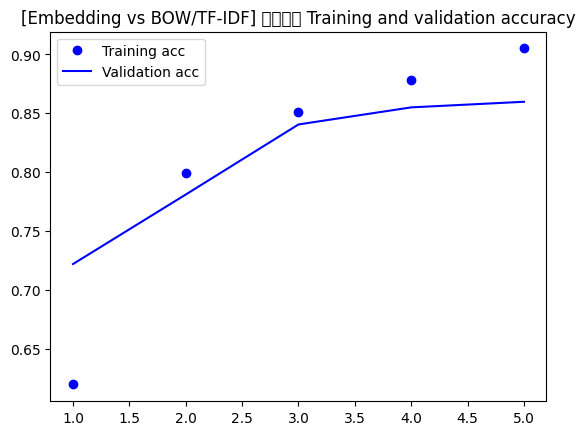

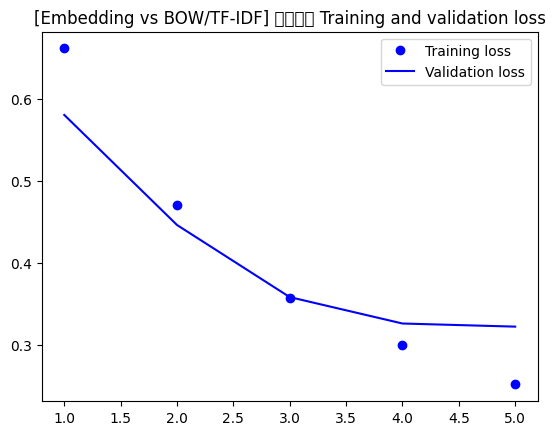

In [7]:
import sys
!{sys.executable} -m pip install scikit-learn

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

def sequences_to_texts(sequences):
    """将整数序列转换为以空格分隔的 token 字符串（便于 sklearn 使用）。"""
    return [" ".join(str(i) for i in seq) for seq in sequences]

train_texts = sequences_to_texts(x_train_raw)
test_texts  = sequences_to_texts(x_test_raw)

print("示例文本：", train_texts[0][:200], "...")

print("\n=== 词袋模型（One-Hot / 计数） ===")
vectorizer_bow = CountVectorizer(
    max_features=MAX_FEATURES,
    token_pattern=r"(?u)\b\w+\b"   # 保留所有 token（包括单个数字）
)
X_train_bow = vectorizer_bow.fit_transform(train_texts)
X_test_bow  = vectorizer_bow.transform(test_texts)
print("BOW 特征矩阵形状：", X_train_bow.shape)

clf_bow = LogisticRegression(max_iter=1000)
clf_bow.fit(X_train_bow, y_train_raw)
y_pred_bow = clf_bow.predict(X_test_bow)
acc_bow = accuracy_score(y_test_raw, y_pred_bow)
print("BOW + LogisticRegression 测试集准确率: {:.4f}".format(acc_bow))

print("\n=== TF-IDF 模型 ===")
vectorizer_tfidf = TfidfVectorizer(
    max_features=MAX_FEATURES,
    token_pattern=r"(?u)\b\w+\b"
)
X_train_tfidf = vectorizer_tfidf.fit_transform(train_texts)
X_test_tfidf  = vectorizer_tfidf.transform(test_texts)
print("TF-IDF 特征矩阵形状：", X_train_tfidf.shape)

clf_tfidf = LogisticRegression(max_iter=1000)
clf_tfidf.fit(X_train_tfidf, y_train_raw)
y_pred_tfidf = clf_tfidf.predict(X_test_tfidf)
acc_tfidf = accuracy_score(y_test_raw, y_pred_tfidf)
print("TF-IDF + LogisticRegression 测试集准确率: {:.4f}".format(acc_tfidf))


print("\n=== Embedding 神经网络 ===")
maxlen_embed = MAXLEN_DEFAULT
embedding_dim_embed = 32

x_train_embed = sequence.pad_sequences(x_train_raw, maxlen=maxlen_embed)
x_test_embed  = sequence.pad_sequences(x_test_raw,  maxlen=maxlen_embed)

model_embed = build_embedding_model(maxlen_embed, embedding_dim_embed)
model_embed.summary()

history_embed = model_embed.fit(
    x_train_embed, y_train_raw,
    epochs=EPOCHS_EMBED,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    verbose=2
)

test_loss_embed, test_acc_embed = model_embed.evaluate(x_test_embed, y_test_raw, verbose=0)
print("Embedding + NN 测试集准确率: {:.4f}".format(test_acc_embed))


results_compare = {
    "bow_logreg": float(acc_bow),
    "tfidf_logreg": float(acc_tfidf),
    "embedding_nn": float(test_acc_embed)
}
print("\n=== 结果汇总 ===")
print(results_compare)

plot_history(history_embed, title_prefix="[Embedding vs BOW/TF-IDF] 选定参数")


我首先对比了不同样本长度 `maxlen` 与嵌入维度 `embedding_dim` 对模型性能的影响。一共测试了 9 组组合（maxlen=100/200/300，embedding_dim=8/16/32）。总体来看，`maxlen=200` 一组的表现最好，其中 `(maxlen=200, embedding_dim=16)` 的测试集准确率最高，约为 **0.8605**。当 `maxlen` 较短（100）时，模型准确率大约在 **0.84** 左右，说明序列过短会丢失部分关键信息；当 `maxlen` 增大到 200 时，准确率提升到 **0.856~0.860** 区间；继续增大到 300，准确率并没有明显提升，甚至某些组合略有下降，说明在本任务下 200 左右的序列长度已经比较合适，过长的序列主要带来计算开销，并没有带来成比例的性能收益。

从嵌入维度来看，`embedding_dim=8` 时整体准确率相对偏低，而 `16` 和 `32` 维的表现比较接近，其中 16 维在多数组合下略优或相当，32 维偶尔略高但差异不明显。这说明在当前样本规模和模型结构下，过大的嵌入维度并不会显著提升效果，反而可能引入更多参数、带来一定的过拟合风险；一个中等大小的嵌入维度（例如 16 维）已经能较好地刻画情感分类所需的信息。

之后我分别使用 **BOW（词袋/计数）+ LogisticRegression**、**TF-IDF + LogisticRegression** 与 **Embedding + 神经网络** 三种方式构建分类器。结果显示：BOW + LR 的测试集准确率约为 **0.8597**，TF-IDF + LR 的准确率最高，约为 **0.8826**，而选定参数下的 Embedding + NN 准确率约为 **0.8566**。可以看到，在这个标准的 IMDB 数据集上，传统的 TF-IDF + 线性分类器仍然非常强，甚至略优于我这里使用的简单 Embedding 网络结构；这也说明在文本分类这类任务上，经典的高维稀疏表示（尤其是 TF-IDF）在样本量足够时依然具有很强的竞争力。

综合来看，Embedding 模型的优势更多体现在：它将稀疏的高维词表示压缩为低维稠密向量，便于后续与更复杂的深度网络（如 LSTM、双向 RNN、Attention 等）端到端结合；而 BOW/TF-IDF 虽然在纯分类任务上效果很好，但难以捕捉词序和上下文结构，特征维度非常高、对内存不够友好。因此，从这个实验我可以得到的结论是：在简单的情感分类任务上，传统方法仍然非常实用，而词嵌入的真正价值，更体现在后续与循环网络或 Transformer 结合时对序列信息的建模能力上。


## LSTM / 堆叠 LSTM / BiLSTM 电影评论分类


In [8]:
# 使用 MAXLEN_RNN 重新做 padding
x_train_rnn = sequence.pad_sequences(x_train_raw, maxlen=MAXLEN_RNN)
x_test_rnn  = sequence.pad_sequences(x_test_raw,  maxlen=MAXLEN_RNN)

print("x_train_rnn shape:", x_train_rnn.shape)
print("x_test_rnn shape:", x_test_rnn.shape)


x_train_rnn shape: (20000, 200)
x_test_rnn shape: (10000, 200)


In [9]:
def build_lstm_model():
    model = models.Sequential()
    model.add(Embedding(MAX_FEATURES, EMBED_DIM_RNN, input_length=MAXLEN_RNN))
    model.add(LSTM(32))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(
        optimizer="rmsprop",
        loss="binary_crossentropy",
        metrics=["acc"]
    )
    return model

def build_stacked_lstm_model():
    model = models.Sequential()
    model.add(Embedding(MAX_FEATURES, EMBED_DIM_RNN, input_length=MAXLEN_RNN))
    model.add(LSTM(32, dropout=0.1, return_sequences=True))
    model.add(LSTM(32, dropout=0.1, return_sequences=True))
    model.add(LSTM(32, dropout=0.1))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(
        optimizer="rmsprop",
        loss="binary_crossentropy",
        metrics=["acc"]
    )
    return model

def build_bilstm_model():
    model = models.Sequential()
    model.add(Embedding(MAX_FEATURES, EMBED_DIM_RNN, input_length=MAXLEN_RNN))
    model.add(Bidirectional(LSTM(32)))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(
        optimizer="rmsprop",
        loss="binary_crossentropy",
        metrics=["acc"]
    )
    return model



=== 单层 LSTM ===


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
125/125 - 4s - 30ms/step - acc: 0.6259 - loss: 0.6368 - val_acc: 0.7510 - val_loss: 0.5199
Epoch 2/5
125/125 - 3s - 25ms/step - acc: 0.8104 - loss: 0.4289 - val_acc: 0.7945 - val_loss: 0.4354
Epoch 3/5
125/125 - 3s - 27ms/step - acc: 0.8474 - loss: 0.3616 - val_acc: 0.8550 - val_loss: 0.3443
Epoch 4/5
125/125 - 3s - 28ms/step - acc: 0.8747 - loss: 0.3022 - val_acc: 0.8555 - val_loss: 0.3396
Epoch 5/5
125/125 - 3s - 28ms/step - acc: 0.8936 - loss: 0.2720 - val_acc: 0.8673 - val_loss: 0.3141
LSTM 测试集准确率: 0.8610


C:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21333 (\N{CJK UNIFIED IDEOGRAPH-5355}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 23618 (\N{CJK UNIFIED IDEOGRAPH-5C42}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


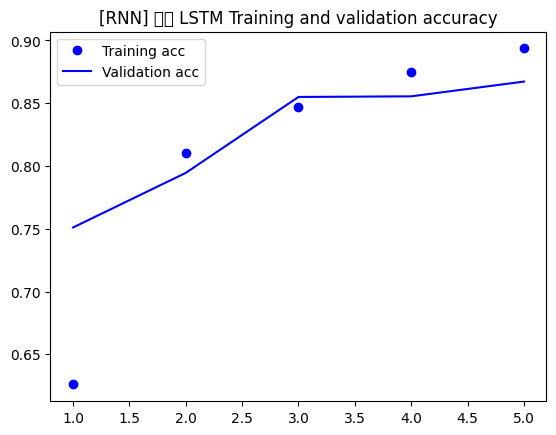

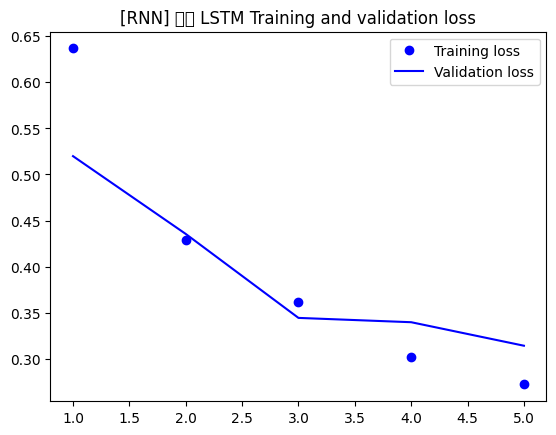


=== 堆叠 LSTM ===


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_11 (Embedding)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
125/125 - 11s - 92ms/step - acc: 0.5446 - loss: 0.6786 - val_acc: 0.5285 - val_loss: 0.8864
Epoch 2/5
125/125 - 10s - 77ms/step - acc: 0.7565 - loss: 0.5150 - val_acc: 0.8192 - val_loss: 0.4169
Epoch 3/5
125/125 - 9s - 72ms/step - acc: 0.8363 - loss: 0.3912 - val_acc: 0.8530 - val_loss: 0.3511
Epoch 4/5
125/125 - 8s - 66ms/step - acc: 0.8641 - loss: 0.3368 - val_acc: 0.8522 - val_loss: 0.3418
Epoch 5/5
125/125 - 8s - 66ms/step - acc: 0.8849 - loss: 0.2910 - val_acc: 0.8727 - val_loss: 0.3260
堆叠 LSTM 测试集准确率: 0.8645


C:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 22534 (\N{CJK UNIFIED IDEOGRAPH-5806}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21472 (\N{CJK UNIFIED IDEOGRAPH-53E0}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


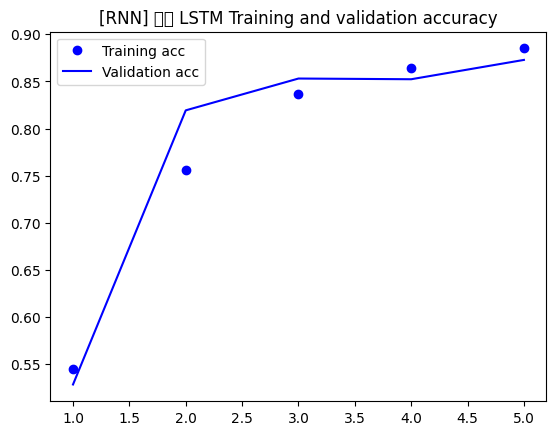

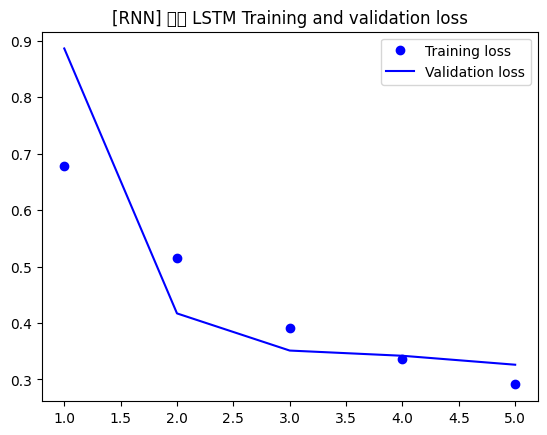


=== BiLSTM ===


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_12 (Embedding)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
125/125 - 6s - 46ms/step - acc: 0.6032 - loss: 0.6525 - val_acc: 0.7132 - val_loss: 0.5502
Epoch 2/5
125/125 - 5s - 39ms/step - acc: 0.7940 - loss: 0.4546 - val_acc: 0.8345 - val_loss: 0.3840
Epoch 3/5
125/125 - 5s - 39ms/step - acc: 0.8474 - loss: 0.3599 - val_acc: 0.8547 - val_loss: 0.3386
Epoch 4/5
125/125 - 5s - 38ms/step - acc: 0.8681 - loss: 0.3221 - val_acc: 0.8630 - val_loss: 0.3313
Epoch 5/5
125/125 - 5s - 39ms/step - acc: 0.8850 - loss: 0.2924 - val_acc: 0.8685 - val_loss: 0.3166
BiLSTM 测试集准确率: 0.8632


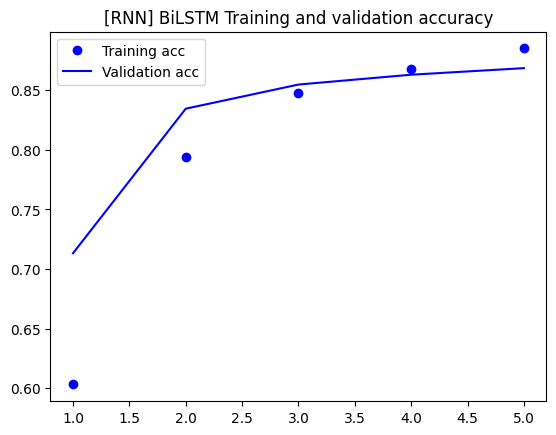

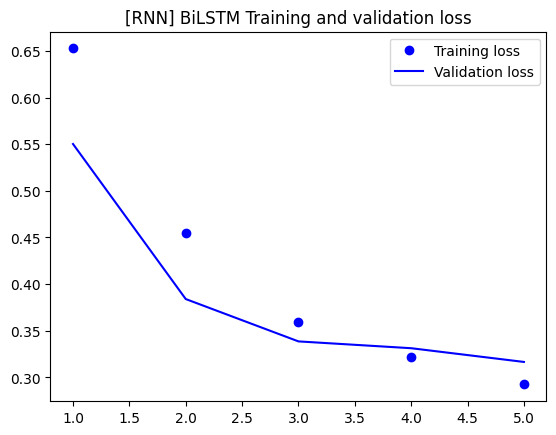


=== RNN 模型结果汇总 ===
{'lstm': 0.8610000014305115, 'stacked_lstm': 0.8644999861717224, 'bilstm': 0.8632000088691711}


In [10]:
rnn_results = {}

print("\n=== 单层 LSTM ===")
model_lstm = build_lstm_model()
model_lstm.summary()
history_lstm = model_lstm.fit(
    x_train_rnn, y_train_raw,
    epochs=EPOCHS_RNN,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    verbose=2
)
test_loss_lstm, test_acc_lstm = model_lstm.evaluate(x_test_rnn, y_test_raw, verbose=0)
rnn_results["lstm"] = float(test_acc_lstm)
print("LSTM 测试集准确率: {:.4f}".format(test_acc_lstm))
plot_history(history_lstm, title_prefix="[RNN] 单层 LSTM")

print("\n=== 堆叠 LSTM ===")
model_stacked = build_stacked_lstm_model()
model_stacked.summary()
history_stacked = model_stacked.fit(
    x_train_rnn, y_train_raw,
    epochs=EPOCHS_RNN,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    verbose=2
)
test_loss_stacked, test_acc_stacked = model_stacked.evaluate(x_test_rnn, y_test_raw, verbose=0)
rnn_results["stacked_lstm"] = float(test_acc_stacked)
print("堆叠 LSTM 测试集准确率: {:.4f}".format(test_acc_stacked))
plot_history(history_stacked, title_prefix="[RNN] 堆叠 LSTM")


print("\n=== BiLSTM ===")
model_bilstm = build_bilstm_model()
model_bilstm.summary()
history_bilstm = model_bilstm.fit(
    x_train_rnn, y_train_raw,
    epochs=EPOCHS_RNN,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    verbose=2
)
test_loss_bilstm, test_acc_bilstm = model_bilstm.evaluate(x_test_rnn, y_test_raw, verbose=0)
rnn_results["bilstm"] = float(test_acc_bilstm)
print("BiLSTM 测试集准确率: {:.4f}".format(test_acc_bilstm))
plot_history(history_bilstm, title_prefix="[RNN] BiLSTM")

print("\n=== RNN 模型结果汇总 ===")
print(rnn_results)


这部分分别实现了三种基于 RNN 的电影评论分类模型：单层 LSTM、堆叠 LSTM 与 BiLSTM。三种模型在同一份 IMDB 数据集上的测试集准确率分别约为：单层 LSTM **0.8610**，堆叠 LSTM **0.8645**，BiLSTM **0.8632**。整体来看，三种模型的性能都处于 0.86 左右的水平，相互之间的差距并不大，其中堆叠 LSTM 略微取得了最好的结果，BiLSTM 其次，单层 LSTM 略低一些。

从结构复杂度与效果的关系来看，堆叠 LSTM 通过增加网络深度，在理论上可以更好地提取高层次的时间序列特征，这在实验结果中表现为：相对于单层 LSTM，测试集准确率大约提升了 0.3% 左右。不过这种提升幅度比较有限，并不是“翻倍式”的改进，同时更深的模型在训练时间和显存占用上都会明显增加，在实际应用中需要权衡资源与收益。

BiLSTM 在结构上通过双向处理序列，能够同时考虑“前文”和“后文”的信息，对于情感分析这种任务，理论上有利于捕捉上下文依赖。从结果上看，BiLSTM 的测试集准确率（约 0.8632）略高于单层 LSTM，也接近堆叠 LSTM，这说明在本任务下，双向结构确实可以带来一定的增益，但提升幅度同样是温和的，并没有远远超过其他两种模型。

综合实验结果可以看出：在当前样本规模和网络设置下，简单的单层 LSTM 已经可以给出比较不错的性能，堆叠 LSTM 和 BiLSTM 虽然在准确率上略有优势，但付出了更多的计算代价。结合 PPT 中对堆叠 RNN 和双向 RNN 的介绍，可以认为这些更复杂的结构更适合在更大规模数据集或更复杂的序列任务中发挥优势；而在本次 IMDB 情感分类这样相对基础的任务中，它们的收益主要体现在小幅的性能提升和对序列信息更精细的建模上，是否采用需要根据实际应用场景来权衡。